#  DSC530-T304 Data Exploration and Analysis - Week 8 #

## Hypothesis Testing & Linear Least Squares ##

### Excercise Chapter 9 & 10 ###
-----

In [1]:
# Download pregency and respondent data files from thinkstat

from os.path import basename, exists

# Declare a function to download the files to local
def download(fileurl):
    filename = basename(fileurl)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(fileurl, filename)
        print("Downloaded " + local)

In [2]:
# Dowload the python and data files to load pregnency and respondent data 
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")

## Chapter 9 ##

**Excercise 9-1**    
As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.
To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [3]:
import numpy as np
import random

In [4]:
# import the script to laod data
import nsfg
import thinkstats2

random.seed(500)

# Load Pregency data in a Dataframe
preg_df = nsfg.ReadFemPreg()
preg_df.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [5]:
# Filter only live birth records
live_birth = preg_df[preg_df.outcome == 1]
len(live_birth)

9148

In [6]:
# Remove records with NA in agepreg and totalwgt_lb from the Dataframe  
live_birth_wo_na = live_birth.dropna(subset=['agepreg', 'totalwgt_lb'])
len(live_birth_wo_na)

9038

In [7]:
from scipy.stats import ttest_ind

# a method to caclculate mean difference
def actualAbsMeanDiff(data1, data2):
    return abs(data1.mean() - data2.mean())

# Shuffle the rows and split the dataframe into two 
def shuffleData(grpData):
    tot_len = len(grpData)
    #Find the 50% size of the dataframe and round down 
    grp1_len = round(tot_len/2)
    #Find the length of other group by deducting the rounded half length
    grp2_len = tot_len - grp1_len
    # shuffle the rows
    np.random.shuffle(grpData)
    # split the rows into two groups
    grp1_data = grpData[:grp1_len]
    grp2_data = grpData[grp1_len:]
    return grp1_data, grp2_data


# Calculate P value from Mean
def customPvalueFromUsingPreshuffleMean(grpData,  pre_shuf_mean):
    test_stats = []
    for _ in range(1000):
        data1, data2 = shuffleData(grpData)
        test_stats.append(actualAbsMeanDiff(data1, data2))
    count = sum(1 for x in test_stats if x >= pre_shuf_mean)
    return count / 1000


# Calculate P value from Correlation
def customPvalueFromUsingPreshuffleCorr(data1, data2, pre_shuf_corr):
    test_stats = []
    for _ in range(1000):
        data_shuff =  np.random.permutation(data1)
        test_stats.append(getCorrelation(data_shuff, data2))
    count = sum(1 for x in test_stats if x >= pre_shuf_corr)
    return count / 1000

# Calculate P value from chi square
def customPvalueFromUsingChiSqr(grpData,  init_chiSq_val, exp_prob):
    test_stats = []
    for _ in range(1000):
        data1, data2 = shuffleData(grpData)
        test_stats.append(ChiSquared(data1, exp_prob ) + ChiSquared(data2, exp_prob))
    count = sum(1 for x in test_stats if x >= init_chiSq_val)
    return count / 1000


# Calculate Correlation between two datasets
def getCorrelation(data1, data2):
    return abs(thinkstats2.Corr(data1, data2))


# Calculate Chi-square value
def ChiSquared(lengths, expProb):
    hist = thinkstats2.Hist(lengths)
    values = range(35, 44)
    observed = np.array(hist.Freqs(values))
    expected = expProb * len(lengths)
    stat = sum((observed - expected)**2 / expected)
    return stat


# Calculate expected probabilities
def getExpectedProbabilitesUsingPMFValues(grpData, lowRng, highRng):
    pmf = thinkstats2.Pmf(grpData)
    values = range(lowRng, highRng)
    return np.array(pmf.Probs(values))

# Execute hypothesis test and calculate P-values
def executeHypothesisTests(liveBirthdata):

    tot_len = len(liveBirthdata)
    # Hypothesis test
    #T-test

    #First baby group data
    #Other baby group data
    first_baby_data       = liveBirthdata[liveBirthdata.birthord == 1]
    other_order_baby_data = liveBirthdata[liveBirthdata.birthord != 1]
    
    # Calculate p-values for the given dataset without shuffling
    t_stat, p_val_1 = ttest_ind(first_baby_data.prglngth.values, other_order_baby_data.prglngth.values)
    t_stat, p_val_2 = ttest_ind(first_baby_data.totalwgt_lb.values, other_order_baby_data.totalwgt_lb.values)
    
    abs_mean_prg_len = actualAbsMeanDiff(first_baby_data.prglngth.values, other_order_baby_data.prglngth.values)
    abs_mean_tot_wt  = actualAbsMeanDiff(first_baby_data.totalwgt_lb.values, other_order_baby_data.totalwgt_lb.values)

    # shuffle and divide into groups to get two samples and calculate p-value using orginal abs mean
    p_val_3 = customPvalueFromUsingPreshuffleMean(liveBirthdata.prglngth.values, abs_mean_prg_len)
    p_val_4 = customPvalueFromUsingPreshuffleMean(liveBirthdata.totalwgt_lb.values, abs_mean_tot_wt)
    
    
    #Find the P-value using Correlation
    abs_corr = getCorrelation(liveBirthdata.prglngth.values, liveBirthdata.totalwgt_lb.values) 
    p_val_5 = customPvalueFromUsingPreshuffleCorr(liveBirthdata.prglngth.values, liveBirthdata.totalwgt_lb.values, abs_corr)
    
    exp_probs = getExpectedProbabilitesUsingPMFValues(liveBirthdata.prglngth.values, 35, 44)
    
    # Find the corrrelation using Chi Squate
    init_chiSq_val  = ChiSquared(first_baby_data.prglngth.values, exp_probs) + ChiSquared(other_order_baby_data.prglngth.values, exp_probs)
    p_val_6 = customPvalueFromUsingChiSqr(liveBirthdata.prglngth.values, init_chiSq_val, exp_probs)
      
    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (tot_len, p_val_1, p_val_2, p_val_3, p_val_4, p_val_5, p_val_6))

    
    
    
    
    
    

In [8]:
import pandas as pd

# Execute a set of iterations by reducing the size of dataframe by 10% per each iteration
df_len = len(live_birth_wo_na)
for i in range(10):
    # deduct multiples of 10% in each iteration
    sampl_len = round(df_len - (df_len*i*10/100))
    # draw sample for the reduced size arrived 
    live_birth_random_data = live_birth_wo_na.sample(n=sampl_len)
    executeHypothesisTests(live_birth_random_data)

9038	0.18	0.00	0.21	0.00	0.86	0.00
8134	0.39	0.00	0.39	0.00	0.59	0.00
7230	0.13	0.00	0.12	0.00	0.18	0.00
6327	0.37	0.00	0.36	0.00	0.54	0.00
5423	0.74	0.01	0.76	0.00	0.40	0.00
4519	0.03	0.04	0.04	0.04	0.70	0.00
3615	0.19	0.00	0.21	0.00	0.17	0.00
2711	0.26	0.01	0.26	0.01	0.86	0.00
1808	0.60	0.01	0.61	0.01	0.97	0.00
904	0.71	0.03	0.71	0.04	0.41	0.01


--------

### Chaper 10 ###

**Excercise 10-1**

Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is finalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [9]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [10]:
# Load the BRFSS data
import brfss
import thinkplot

bio_met_df = brfss.ReadBrfss(nrows=None)
bio_met_df = bio_met_df.dropna(subset=['htm3', 'wtkg2'])
height_val, weight_val = bio_met_df.htm3, bio_met_df.wtkg2

In [11]:
# compute the linear least squares fit for log(weight) versus height.
log_weight_val = np.log10(weight_val)
slope_log, intercept_log = np.polyfit(height_val, log_weight_val, deg=1)

In [12]:
print("Coefficent of linear least squares fit Slope     : ",  slope_log)
print("Coefficent of linear least squares fit Intercept : ",  intercept_log)

Coefficent of linear least squares fit Slope     :  0.005281454169417811
Coefficent of linear least squares fit Intercept :  0.9930804163933085


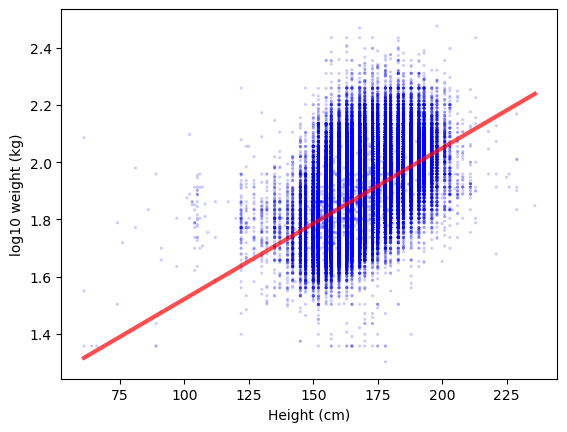

In [13]:
# present the estimated parameters for a model like this where one of the variables is log-transformed
# If you were trying to guess someone’s weight, how much would it help to know their heigh

# fitted line for a sequence and plot it using log 10 values of weight
fxs, fys = thinkstats2.FitLine(height_val, intercept_log, slope_log)
thinkplot.Scatter(height_val, log_weight_val, s=5)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)


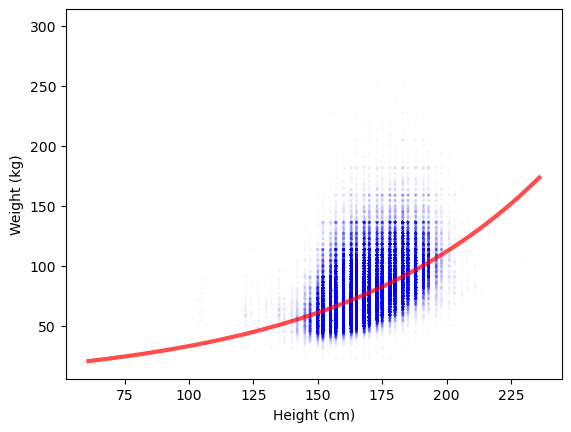

In [14]:
# Plot with normal values
thinkplot.Scatter(height_val, weight_val, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(height_val, intercept_log, slope_log)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

In [15]:
# calculate the residuals using the intercept, slope and height and log10 weight feature values
residuals = thinkstats2.Residuals(height_val, log_weight_val, intercept_log, slope_log)

In [16]:
bio_met_df['residuals'] = residuals

In [17]:
# sort the dataframe by weight to group that data 
bio_met_df = bio_met_df.sort_values(by='htm3')

# Add group id to the data to bins using the age range ,  break them into 20 groups 
bio_met_df['Percentile'] = pd.qcut(bio_met_df['htm3'], q=10, labels=False)

In [18]:
bio_met_df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3,residuals,Percentile
59274,63.0,1,121.818182,127.586686,121.82,61.0,0.770469,0
230974,80.0,2,22.727273,497.829044,22.73,61.0,0.041350,0
231404,68.0,2,31.363636,121.943585,35.45,61.0,0.234367,0
230107,57.0,2,22.727273,208.543561,22.73,64.0,0.025506,0
229805,80.0,2,45.454545,466.020365,22.73,66.0,0.014943,0


In [19]:
grouped_data = bio_met_df.groupby('Percentile')

In [20]:
# find the mean value of the age  for each group
hgts = [group.htm3.mean() for i, group in grouped_data]
# find the cdf value for each record in the group
cdfs = [thinkstats2.Cdf(group.residuals) for i, group in grouped_data]

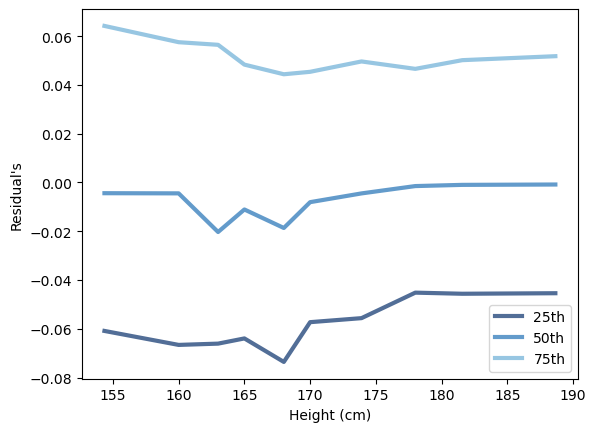

In [21]:
thinkplot.PrePlot(3)

# Find the 25th percentile for each group among the cdf values  and plot them
hght1 = [cdf.Percentile(25) for cdf in cdfs]
thinkplot.Plot(hgts, hght1, label='25th')

# Find the 50th percentile for each group among the cdf values and plot them
hght1 = [cdf.Percentile(50) for cdf in cdfs]
thinkplot.Plot(hgts, hght1, label='50th')

# Find the 75th percentile for each group among the cdf values and plot them
hght1 = [cdf.Percentile(75) for cdf in cdfs]
thinkplot.Plot(hgts, hght1, label='75th')

thinkplot.Config(xlabel='Height (cm)',
                     ylabel="Residual's",
                      legend=True)

**Guess someone’s weight, how much would it help to know their height**

In [22]:

#  From the percentile plot,  the median is close to 0  and this ensure that given the weight ,  the height can be guessed.

#Determine the correlation
ht_logwt_corr = thinkstats2.Corr(height_val, log_weight_val)
print(ht_logwt_corr)

0.5317282605983413


***Correlation is 0.53 which between 0 to 1 showing a good correlation and a good fit to guess the height for given weight***

In [23]:
# Find Spearman co-relation and P-value
from scipy.stats import spearmanr

rho, p_value = spearmanr(height_val, log_weight_val)
print("Spearman correlation coefficient (rho):", rho)
print("P-value:", p_value)

Spearman correlation coefficient (rho): 0.5405846262320476
P-value: 0.0


***P-value is 0  which shows very good co-relation and a confirms the it is good to guess the height for given weight***

In [24]:
#  Validate Standard deviation of residuals which is a measure of RMSE 
# as it is actual vs predicted values in the intercept of linear regression
std_dev = np.std(residuals)

print("Standard deviation using NumPy:", std_dev)

Standard deviation using NumPy: 0.08740777080416087


***Standard Deviation is less than 0.1 which indicates a close nit of values along the linear line and the difference between predicted and actual is less***


.

In [25]:
# Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, 
# calculating the standard error of the mean, and a 90% confidence interval.

In [35]:
# use the height and weight feature wtkg2 to calculate mean, standard Error and Confidence interval at 90%
sample_unweighted = [thinkstats2.ResampleRows(bio_met_df).htm3.mean() for k in range(100)]
unwgt_mean   = thinkstats2.Mean(sample_unweighted)
unwgt_stderr = thinkstats2.Std(sample_unweighted, mu=None)
unwgt_cdf    = thinkstats2.Cdf(sample_unweighted)
unwgt_ci     = unwgt_cdf.ConfidenceInterval(90)
print('Unweighted weights -> Mean: %0.2f\t, Standard Error: %0.2f\t'  % (unwgt_mean, unwgt_stderr ))
print('Confidence Interval 90: %0.2f\t%0.2f\t' % (unwgt_ci[0], unwgt_ci[1]))

Unweighted weights -> Mean: 168.96	, Standard Error: 0.02	
Confidence Interval 90: 168.93	168.98	


In [36]:
# use the height and total weight feature finalwt to calculate mean, standard Error and Confidence interval at 90%
sample_weighted = [thinkstats2.ResampleRowsWeighted(bio_met_df, 'finalwt').htm3.mean() for k in range(100)]
wgtd_mean   = thinkstats2.Mean(sample_weighted)
wgtd_stderr = thinkstats2.Std(sample_weighted, mu=None)
wgtd_cdf    = thinkstats2.Cdf(sample_weighted)
wgtd_ci     = wgtd_cdf.ConfidenceInterval(90)
print('Unweighted weights -> Mean: %0.2f\t, Standard Error: %0.2f\t' %(wgtd_mean, wgtd_stderr))
print('Confidence Interval 90: %0.2f\t%0.2f\t' % (wgtd_ci[0], wgtd_ci[1]))

Unweighted weights -> Mean: 170.50	, Standard Error: 0.02	
Confidence Interval 90: 170.47	170.52	
